# Generate Correlated Assets 
## Black Scholes Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let $\left( \Omega , \mathcal{F}, \mathbb{P} \right)$ a complete probability space, $T>0$ a finite horizon      
Suppose that our universe is made of $n$ assets with the following dynamics : 
$$
\begin{align*}
    \frac{dS_t^i}{S_t^i} &= \left( \mu_i - q_i \right) dt + \sigma_i dW_t^i  \\
    S_t^i &= S_0^i
\end{align*}
$$
where $\left( \hat{W_t}^1, \hat{W_t}^2, ... \hat{W_t}^n \right)$ are correlated brownian motion, i.e :
$$
\begin{equation*}
    \mathbb{E} \left[ \hat{W_t}^i \hat{W_t}^j \right] = \rho_{ij} dt
\end{equation*}
$$

In fact one can rewrite with matrix notation what has been written above :       
Let $\left( S_t \right)_{t \geq 0} \in \mathbb{R}^n $ be the vector price, $\left( \hat{W_t} \right)_{t \geq 0} \in \mathbb{R}^n$ the correlated brownian vector, $\mu \in \mathbb{R}^n$ the return vector and $q \in \mathbb{R}^n$ the dividend vector  such that :
$$
\begin{align*}
S_t &= \left( S_t^1, S_t^2, ... , S_t^n \right) \\
\hat{W}_t &= \left( \hat{W_t}^1, \hat{W_t}^2, ... \hat{W_t}^n \right) \\
\mu &= \left( \mu^1 , \mu^2 , ... , \mu^n \right) \\
q &= \left( q^1, q^2, ... , q^n \right) 
\end{align*}
$$ 

Therefore : 
$$
\begin{align*}
    dS_t &= S_t \left[ \left( \mu - q \right)dt + \Sigma d\hat{W}_t \right] \\
    S_0 &= S_0
\end{align*}
$$

Let's first remark that the correlated brownian vector is a gaussian vector,
therefore if we denote by $R \in \mathbb{M}_{n,n} \left( \mathbb{R}\right)$ we can generate a vector of uncorrelated brownian $W$,
take $L$ the cholesky decomposition of $R$ and : $\Sigma d\hat{W}_t = \Sigma L dW_t$    
thus : 
$$
\begin{align*}
    dS_t &= S_t \odot \left[ \left( \mu - q \right)dt + \Sigma L dW_t \right] \\
    S_0 &= S_0
\end{align*}
$$

Furthermore, as there is an analytic solution to the Black-Scholes SDE, One can rewrite the process as : 
$$
\begin{align*}
    S_t = S_0 \odot \exp \left( \left( \mu - q - \frac{1}{2} \Sigma \Sigma^T \right)t + \Sigma L W_t \right)
\end{align*}
$$

What we can first remark is that for simulation purpose, there are some steps :        
- generate uncorrelated brownian 
- compute the cholesky decomposition of the correlation matrix
- compute the dot product of everything

In [345]:
sigma = np.array([0.6, 0.4])
S0 = np.array([100,80])
rho = np.array([[1.0, -0.3], [-0.3, 1.0]])
mu = np.array([0.2, 0.5])
q = np.array([0.1, 0.1])
T = 1
n_time = 50
n_mc = 2000

n_underlying = len(S0)
d = n_underlying*n_mc
t = np.linspace(0, T, n_time+1)
h = T / n_time

The first part is to generate uncorrelated brownian motions. Here the simplest and fastest way to do so is to go by the definition of a standard brownian motion : 
- $W_0$ = 0 
- $W_t - W_s \perp \sigma \left( W_u \right) $
- $W_t - W_s \sim \mathcal{N} \left( 0, t-s \right)$

In [346]:
W = np.insert(np.random.normal(scale=np.sqrt(h), size=(d, n_time)).cumsum(axis=1), 0, 0, axis=1)

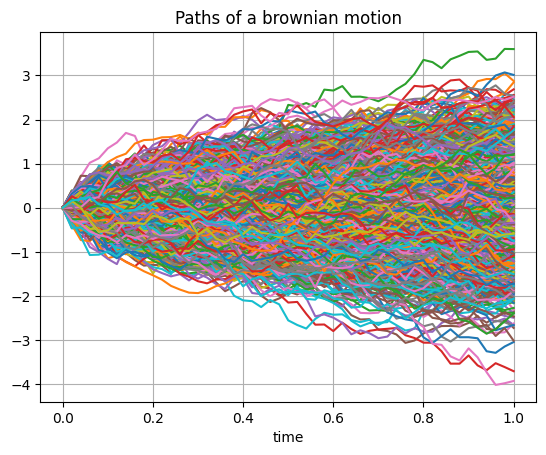

In [348]:
for k in range(n_mc):
    plt.plot(t,W[k,:])

plt.title("Paths of a brownian motion")
plt.xlabel("time")
plt.grid()
plt.show()

In [353]:
t_mat = np.linspace(0,T,n_time+1)
s_mat = np.linspace(0,T,n_time +1)
T_mesh,S_mesh = np.meshgrid(t_mat,s_mat)
Mat = np.minimum(T_mesh,S_mesh) 
Mat_empirique = np.cov(W.T)

print(f"L_inf error : ",np.abs(Mat-Mat_empirique).max())

L_inf error :  0.035245403086399674


In [339]:
L = np.linalg.cholesky(rho)
sigma_mat = np.diag(sigma)
mat = np.dot(sigma_mat, L)

In [340]:
mat

array([[ 0.6       ,  0.        ],
       [-0.12      ,  0.38157568]])

In [313]:
np.dot(mat, mat.T)

array([[ 0.36 , -0.072],
       [-0.072,  0.16 ]])

In [314]:
correlated_W = np.zeros(W.shape)
for k in range(n_mc):
    correlated_W[k*n_underlying:(k+1)*n_underlying,:] = np.dot(mat[:,np.newaxis],W[k*n_underlying:(k+1)*n_underlying,:]).reshape((n_underlying,n_time+1))

In [315]:
correlated_W.shape

(60000, 501)

In [325]:
S = np.zeros((n_mc*n_underlying,n_time+1))
for k in range(n_mc):
    for j in range(n_time+1):
        S[k*n_underlying:(k+1)*n_underlying,j] = S0*np.exp( ((mu-q) - sigma**2)*t[j] + correlated_W[k*n_underlying:(k+1)*n_underlying,j] )

In [326]:
S

array([[100.        , 101.15919529, 103.20047085, ...,  61.93428501,
         61.61145347,  60.29094968],
       [ 80.        ,  82.2414271 ,  81.12842272, ...,  58.96962396,
         60.31111674,  61.36131609],
       [100.        , 100.94439133,  97.86828024, ...,  25.65997711,
         25.48136432,  25.90639605],
       ...,
       [ 80.        ,  79.00116691,  78.04971801, ..., 114.54283674,
        114.79516472, 112.89442605],
       [100.        , 101.36277305,  96.46971248, ..., 209.11970415,
        204.68618086, 204.77932819],
       [ 80.        ,  80.05413571,  82.66742373, ..., 100.54784712,
        100.88294189, 103.98825166]])

In [324]:
temp = np.zeros(shape = (n_underlying, n_mc))
temp2 = np.zeros(shape = (n_underlying, n_mc))
for k in range(n_mc):
    temp[:,k] = correlated_W[k * n_underlying:(k + 1) * n_underlying, -1]
    temp2[:,k] = np.log(S[k * n_underlying:(k + 1) * n_underlying, -1])

In [318]:
np.corrcoef(temp)

array([[ 1.        , -0.29571625],
       [-0.29571625,  1.        ]])

In [319]:
np.corrcoef(temp2)

array([[ 1.        , -0.29571625],
       [-0.29571625,  1.        ]])

In [320]:
np.cov(temp)

array([[ 0.35822267, -0.07086845],
       [-0.07086845,  0.16032544]])

In [321]:
np.cov(temp2)

array([[ 0.35822267, -0.07086845],
       [-0.07086845,  0.16032544]])

In [322]:
np.dot(mat, mat.T)

array([[ 0.36 , -0.072],
       [-0.072,  0.16 ]])

In [166]:
np.corrcoef(temp)

array([[1.        , 0.30326433],
       [0.30326433, 1.        ]])